In [1]:
# base imports
import nltk
import pandas as pd


### Setup Steps

In [2]:
salaryData = pd.read_csv('data/Train_rev1.csv')[['FullDescription', 'SalaryNormalized']][:1000]

In [3]:
top_quartile = salaryData['SalaryNormalized'].describe()['75%']
salaryData['high'] = (salaryData['SalaryNormalized'] > top_quartile).astype(int)
salaryData.drop('SalaryNormalized', axis=1, inplace=True)

In [4]:
# data splits
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(salaryData['FullDescription'],
                                                    salaryData['high'],
                                                    test_size=0.4, random_state=1)

### B1 Bag-of-words

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
trainVectorizer = CountVectorizer(min_df=1)

In [6]:
trainVectorCount = trainVectorizer.fit_transform(X_train)
testVectorCount = trainVectorizer.transform(X_test)

In [7]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
model = classifier.fit(trainVectorCount, y_train)

In [8]:
from sklearn.metrics import confusion_matrix
y_hat_train = model.predict(trainVectorCount)

cm = confusion_matrix(y_train,y_hat_train)
y_hat_test = model.predict(testVectorCount)
cm2 = confusion_matrix(y_test,y_hat_test)
print cm2

[[258  35]
 [ 23  84]]


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


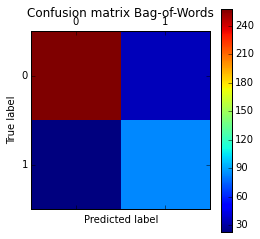

In [9]:
%pylab inline
plt.matshow(cm2)
plt.title('Confusion matrix Bag-of-Words')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### B2 Lemmatization

We would expect that the lemmatization model would perform better since it is not tokenizing based only on punctuation but on the root of the word. This would in theory mean that a classification model would be able to classify documents based on the root words instead of particular conjugations and thus perform better since there are fewer features (i.e. multiple conjugations/features collapse into one root).

In [10]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

LemmaVector = CountVectorizer(tokenizer=LemmaTokenizer())

In [11]:
trainVectorLemma = LemmaVector.fit_transform(X_train)
testVectorLemma = LemmaVector.transform(X_test)

In [12]:
classifierLemma = MultinomialNB()
modelLemma = classifierLemma.fit(trainVectorLemma, y_train)

In [13]:
y_hat_trainLemma = modelLemma.predict(trainVectorLemma)

y_hat_testLemma = modelLemma.predict(testVectorLemma)
cm3 = confusion_matrix(y_test,y_hat_testLemma)
print cm3

[[257  36]
 [ 26  81]]


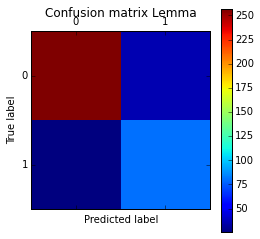

In [14]:
plt.clf()
plt.matshow(cm3)
plt.title('Confusion matrix Lemma')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Somewhat counterintuitively, the lemmatization model did not perform noticably better or worse from the simpler stemming model despite being much more computationally expensive.

### B3 Stopwords

In [15]:
stopwordVector = CountVectorizer(stop_words='english',
                                tokenizer=LemmaTokenizer())

In [16]:
trainStopwordsVector = stopwordVector.fit_transform(X_train)
testStopwordsVector = stopwordVector.transform(X_test)

In [17]:
classifierStopwords = MultinomialNB()
modelStopwords = classifierStopwords.fit(trainStopwordsVector, y_train)

In [18]:
y_hat_trainStopwords = modelStopwords.predict(testStopwordsVector)
cm4 = confusion_matrix(y_test, y_hat_trainStopwords)
print cm4

[[255  38]
 [ 25  82]]


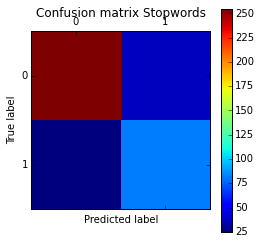

In [19]:
plt.clf()
plt.matshow(cm4)
plt.title('Confusion matrix Stopwords')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [20]:
modelCoefficients = modelStopwords.coef_[0]
modelFeatures = stopwordVector.get_feature_names()

In [21]:
feature_Coeffs = []
if len(modelCoefficients)==len(modelFeatures):
    for i in range(len(modelCoefficients)):
        feature_Coeffs.append((modelFeatures[i], modelCoefficients[i]))

In [22]:
from operator import itemgetter
feature_Coeffs = sorted(feature_Coeffs,key=itemgetter(1))

Top 10 High Salary Features:

In [23]:
feature_Coeffs[-10:]

[(u'management', -5.0731300615245907),
 (u':', -4.8963795497800913),
 (u'experience', -4.7656453617766301),
 (u'nursing', -4.6765935841607273),
 (u'****', -4.4927783751099897),
 (u'care', -4.4489757524515969),
 (u'manager', -4.1357303664402005),
 (u'home', -4.0176572655170988),
 (u',', -3.2758304119209205),
 (u'.', -3.0843428881128849)]

Top 10 Low Salary Features

In [24]:
feature_Coeffs[:10]

[(u"'children", -10.083765355620846),
 (u"'d", -10.083765355620846),
 (u"'investors", -10.083765355620846),
 (u"'rgn", -10.083765355620846),
 (u"'take", -10.083765355620846),
 (u"'ve", -10.083765355620846),
 (u"'work", -10.083765355620846),
 (u'********', -10.083765355620846),
 (u'********phr', -10.083765355620846),
 (u'****.5', -10.083765355620846)]

### B4 Part-of-Speech Bi-grams

In [25]:
def pos_BiGramizer(doc):
    tokens = nltk.word_tokenize(doc.lower())
    tagged = nltk.pos_tag(tokens)
    ord_pos = [y for x, y in tagged]
    pos_BiGrams = []
    for i in range(len(ord_pos)-1):
        pos_BiGrams.append(ord_pos[i] + '_' + ord_pos[i+1])
    return list(pos_BiGrams)

In [26]:
def pos_BG_count_tokenizer(doc):
    return nltk.word_tokenize(doc) + pos_BiGramizer(doc)

In [27]:
class POS_BG_Tokenizer(object):
    def __call__(self, doc):
        return pos_BG_count_tokenizer(doc)

In [28]:
posBGVector = CountVectorizer(stop_words='english',
                                tokenizer=POS_BG_Tokenizer())

In [29]:
trainBGVector = posBGVector.fit_transform(X_train)
testBGVector = posBGVector.transform(X_test)

In [30]:
classifierBG = MultinomialNB()
modelBG = classifierBG.fit(trainBGVector, y_train)

In [31]:
y_hat_trainBG = modelBG.predict(testBGVector)
cm5 = confusion_matrix(y_test, y_hat_trainBG)
print cm5

[[259  34]
 [ 23  84]]


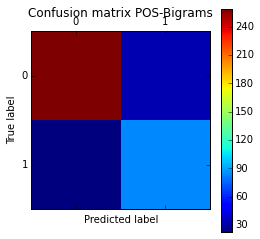

In [32]:
plt.clf()
plt.matshow(cm5)
plt.title('Confusion matrix POS-Bigrams')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()